# Task 2

---

## Predictive modeling of customer bookings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from tqdm import tqdm

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import airportsdata
import eli5

COLOR_FONT = 'dimgray'
COLOR_PLOT = 'tan'

plt.rcParams.update(
    {
        'text.color': COLOR_FONT,
        'axes.edgecolor': COLOR_FONT,
        'axes.labelcolor': COLOR_FONT,
        'axes.titlecolor': COLOR_FONT,
        'axes.titlesize': 14,
        'xtick.color': COLOR_FONT,
        'ytick.color': COLOR_FONT,
        'xtick.bottom': False,
        'ytick.left': False,
    }
)

In [2]:
df = pd.read_csv('./data/customer_booking.csv', encoding='ISO-8859-1')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df['flight_day'].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    'Mon': 1,
    'Tue': 2,
    'Wed': 3,
    'Thu': 4,
    'Fri': 5,
    'Sat': 6,
    'Sun': 7,
}

df['flight_day'] = df['flight_day'].map(mapping)

In [6]:
df['flight_day'].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

Our goal is to predictis whether a customer will make a booking (`booking_complete`).

Our plan: 
- encode categoracal features by using:
    - LabelEncoder
    - OneHot Encoder
- feature engineering
- feature importance 



In [7]:
df['booking_complete'].value_counts(normalize=True)

0    0.85044
1    0.14956
Name: booking_complete, dtype: float64

Only 15% of customer made a booking. 

Let's check for duplicates.

In [8]:
sum(df.duplicated())

719

There are 719 duplicates. Drop all this rows.

In [9]:
df.drop_duplicates(inplace=True)
df.shape

(49281, 14)

#### Baseline Model

Dataset is not too large and unbalanced, so we can use Stratified K-fold Cross-validation.

There is no test dataset, so create it separating 20% from the dataset to run the model only once to find out the final result.

Use the roc_auc metric because we need to identify the most promising clients for working with them.

In [10]:
X, y = df.drop('booking_complete', axis=1), df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24, stratify=y
)
X_train.shape, X_test.shape

((39424, 13), (9857, 13))

In [11]:
def train_model(model, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
    cv_score = np.mean(cross_val_score(model, X, y, cv=skf, scoring='roc_auc'))
    print(f'roc_auc score: {cv_score}')

In [12]:
classifier = ExtraTreesClassifier(max_depth=7, random_state=24)

train_model(classifier, X_train.select_dtypes('number'), y_train)

roc_auc score: 0.649695546189411


In [13]:
classifier = RandomForestClassifier(max_depth=7, random_state=24)

train_model(classifier, X_train.select_dtypes('number'), y_train)

roc_auc score: 0.6762964062293414


Calculate class weight for classifier model, becuase of unbalanced classes.

In [14]:
df['booking_complete'].value_counts()

0    41890
1     7391
Name: booking_complete, dtype: int64

In [15]:
# class 1
print(49281 / (2 * 7391))
# class 0
print(49281 / (2 * 41890))

3.333851982140441
0.5882191453807591


In [16]:
class_weight = {0: 0.6, 1: 3.3}

In [17]:
classifier = RandomForestClassifier(
    max_depth=7, random_state=24, class_weight=class_weight
)

train_model(classifier, X_train.select_dtypes('number'), y_train)

roc_auc score: 0.6776582562101762


In [18]:
classifier.fit(X_train.select_dtypes('number'), y_train)
eli5.show_weights(
    classifier, feature_names=X_train.select_dtypes('number').columns.values
)

Weight,Feature
0.3301 ± 0.1465,flight_duration
0.2833 ± 0.1213,length_of_stay
0.1237 ± 0.0657,wants_extra_baggage
0.0911 ± 0.0470,purchase_lead
0.0637 ± 0.0342,flight_hour
0.0346 ± 0.0321,wants_preferred_seat
0.0262 ± 0.0279,wants_in_flight_meals
0.0261 ± 0.0179,flight_day
0.0212 ± 0.0167,num_passengers


We'll choose the RandomForestClassifier model with weighted classes as the baseline model. 

The most importance features are `flight_duration` and `length_of_stay`.

#### Encoding the categorical features

In [19]:
categorical_features = X_train.select_dtypes('object').columns.to_list()
categorical_features

['sales_channel', 'trip_type', 'route', 'booking_origin']

In [20]:
model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), categorical_features),
        remainder='passthrough',
        verbose_feature_names_out=False,
    ),
    RandomForestClassifier(max_depth=7,
                           random_state=24,
                           class_weight=class_weight),
)

train_model(model, X_train, y_train)

roc_auc score: 0.7652958000239463


In [21]:
model = make_pipeline(
    make_column_transformer(
        (
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            categorical_features,
        ),
        remainder='passthrough',
        verbose_feature_names_out=False,
    ),
    RandomForestClassifier(max_depth=7,
                           random_state=24,
                           class_weight=class_weight),
)

train_model(model, X_train, y_train)

roc_auc score: 0.7566633567174983


The OneHotEncoder gives better result.

### Feature Engineering

In [22]:
for feat in categorical_features:
    print(feat, '\n', df[feat].value_counts(), '\n')

sales_channel 
 Internet    43917
Mobile       5364
Name: sales_channel, dtype: int64 

trip_type 
 RoundTrip     48779
OneWay          386
CircleTrip      116
Name: trip_type, dtype: int64 

route 
 AKLKUL    2620
PENTPE     912
MELSGN     833
ICNSIN     793
DMKKIX     729
          ... 
AKLHGH       1
JEDPDG       1
JEDPEN       1
DACPEK       1
MRUXIY       1
Name: route, Length: 799, dtype: int64 

booking_origin 
 Australia               17691
Malaysia                 7055
South Korea              4502
Japan                    3819
China                    3284
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64 



Create two separate columns with route origin and destination instead of one `route`. 

In [23]:
df['route_origin'] = df['route'].str[:3]
df['route_origin'].value_counts()

DMK    3698
ICN    3681
MEL    3427
DPS    2840
AKL    2788
       ... 
CSX       4
NRT       2
CXR       1
BTJ       1
URT       1
Name: route_origin, Length: 85, dtype: int64

In [24]:
df['route_destination'] = df['route'].str[-3:]
df['route_destination'].value_counts()

SYD    6543
PER    4940
MEL    4392
TPE    3989
OOL    2776
       ... 
SWA       3
NRT       1
PDG       1
LBU       1
SRG       1
Name: route_destination, Length: 64, dtype: int64

Look at column `booking_origin`

In [25]:
df['booking_origin'].value_counts(dropna=False)

Australia               17691
Malaysia                 7055
South Korea              4502
Japan                    3819
China                    3284
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64

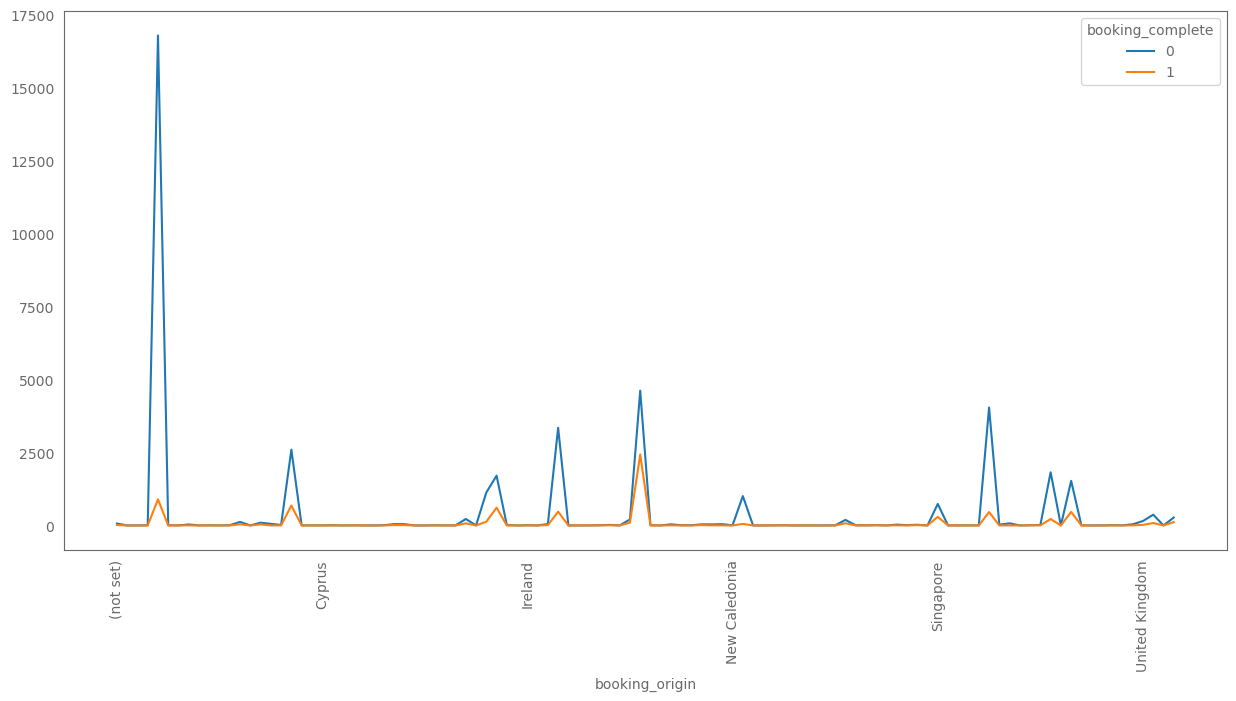

In [26]:
df_plot = (
    df.groupby(['booking_origin', 'booking_complete'])['booking_complete']
    .agg('count')
    .unstack()
    .fillna(0)
)

df_plot.plot(figsize=(15, 7))

plt.xticks(rotation=90)
plt.show()

In [27]:
df[df['booking_complete'] == 1]['booking_origin'].value_counts()[:10]

Malaysia       2434
Australia       895
China           684
Indonesia       609
Japan           472
Thailand        464
South Korea     459
Singapore       295
Taiwan          220
India           128
Name: booking_origin, dtype: int64

In [28]:
df[df['booking_complete'] == 0]['booking_origin'].value_counts()[:10]

Australia      16796
Malaysia        4621
South Korea     4043
Japan           3347
China           2600
Taiwan          1822
Indonesia       1708
Thailand        1529
India           1130
New Zealand     1007
Name: booking_origin, dtype: int64

Let's transform countries to their geocoordinates. 

In [29]:
geolocator = Nominatim(user_agent='my_request')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.3)

country_coordinates = {}
for country in tqdm(df['booking_origin'].unique()):
    try:
        location = geolocator.geocode(country)
        country_coordinates[country] = location.latitude, location.longitude
    except:
        country_coordinates[country] = None, None

100%|██████████| 104/104 [00:54<00:00,  1.92it/s]


In [30]:
country_coordinates

{'New Zealand': (-41.5000831, 172.8344077),
 'India': (22.3511148, 78.6677428),
 'United Kingdom': (54.7023545, -3.2765753),
 'China': (35.000074, 104.999927),
 'South Korea': (36.638392, 127.6961188),
 'Japan': (36.5748441, 139.2394179),
 'Malaysia': (4.5693754, 102.2656823),
 'Singapore': (1.357107, 103.8194992),
 'Switzerland': (46.7985624, 8.2319736),
 'Germany': (51.1638175, 10.4478313),
 'Indonesia': (-2.4833826, 117.8902853),
 'Czech Republic': (49.7439047, 15.3381061),
 'Vietnam': (15.9266657, 107.9650855),
 'Thailand': (7.4931858, 124.724704),
 'Spain': (39.3260685, -4.8379791),
 'Romania': (45.9852129, 24.6859225),
 'Ireland': (52.865196, -7.9794599),
 'Italy': (42.6384261, 12.674297),
 'Slovakia': (48.7411522, 19.4528646),
 'United Arab Emirates': (24.0002488, 53.9994829),
 'Tonga': (-19.9160819, -175.202642),
 'Réunion': (-21.1309332, 55.5265771),
 '(not set)': (9.326573849999999, 76.5380997348222),
 'Saudi Arabia': (25.6242618, 42.3528328),
 'Netherlands': (52.2434979, 5.6

In [31]:
country_coordinates['(not set)'] = 0, 0

In [32]:
def get_coordinates(country):
    lat = country_coordinates[country][0]
    lon = country_coordinates[country][1]
    return lat, lon


df[['booking_origin_latitude', 'booking_origin_longitude']] = (
    df['booking_origin'].apply(get_coordinates).apply(pd.Series)
)

df[['booking_origin_latitude', 'booking_origin_longitude']]

,booking_origin_latitude,booking_origin_longitude
0,-41.500083,172.834408
1,-41.500083,172.834408
2,22.351115,78.667743
3,-41.500083,172.834408
4,22.351115,78.667743
...,...,...
49995,-24.776109,134.755000
49996,-24.776109,134.755000
49997,-24.776109,134.755000
49998,-24.776109,134.755000


In [33]:
del df['booking_origin'], df['route']

In [34]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'wants_extra_baggage',
       'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration',
       'booking_complete', 'route_origin', 'route_destination',
       'booking_origin_latitude', 'booking_origin_longitude'],
      dtype='object')

In [35]:
X, y = df.drop('booking_complete', axis=1), df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24, stratify=y
)

categorical_features = X_train.select_dtypes('object').columns.to_list()

In [36]:
model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), categorical_features),
        remainder='passthrough',
        verbose_feature_names_out=False,
    ),
    RandomForestClassifier(max_depth=7,
                           random_state=24,
                           class_weight=class_weight),
)

train_model(model, X_train, y_train)

roc_auc score: 0.7679588768683641


In [37]:
model.fit(X_train, y_train)
explanation = eli5.explain_weights(
    model[1], top=15, feature_names=model[0].get_feature_names_out()
)
df_feature_importance = eli5.format_as_dataframe(explanation)
df_feature_importance

,feature,weight,std
0,booking_origin_longitude,0.313200,0.277171
1,booking_origin_latitude,0.202013,0.246381
2,flight_duration,0.064788,0.090637
3,length_of_stay,0.052547,0.071740
4,route_origin_PEN,0.037733,0.060179
5,wants_extra_baggage,0.034570,0.042875
6,route_destination_SYD,0.025539,0.044891
7,route_destination_PEN,0.020961,0.034708
8,purchase_lead,0.015399,0.013520
9,route_origin_CMB,0.014054,0.032105


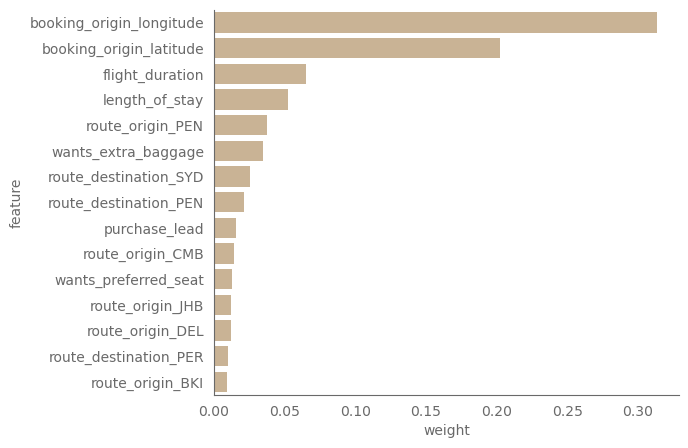

In [38]:
plt.figure(figsize=(6, 5))
ax = sns.barplot(df_feature_importance, y='feature', x='weight', color=COLOR_PLOT)
ax.spines[['top', 'right']].set_visible(False)
plt.show()

Let's combine two important features: `length_of_stay` and `flight_duration`.

In [39]:
df['length_of_stay_per_flight_duration'] = (df['length_of_stay']
                                            / df['flight_duration'])

Let's convert airports in route to they geodata.

In [40]:
airports = airportsdata.load('IATA')

In [41]:
route_airports = np.concatenate(
    (df['route_origin'].unique(), df['route_destination'].unique())
)

In [42]:
route_coordinates = {}

for airport in route_airports:
    route_coordinates[airport] = (airports[airport]['lat'],
                                  airports[airport]['lon'])

route_coordinates

{'AKL': (-37.0081, 174.79201),
 'AOR': (6.18967, 100.398),
 'BBI': (20.2444, 85.8178),
 'BDO': (-6.90063, 107.576),
 'BKI': (5.93721, 116.051),
 'BLR': (13.1979, 77.7063),
 'BOM': (19.0887, 72.8679),
 'BTJ': (5.52352, 95.4204),
 'BTU': (3.12385, 113.02),
 'BWN': (4.9442, 114.928),
 'CAN': (23.3924, 113.299),
 'CCU': (22.6547, 88.4467),
 'CEB': (10.3075, 123.979),
 'CGK': (-6.12557, 106.656),
 'CKG': (29.7192, 106.642),
 'CMB': (7.18076, 79.8841),
 'CNX': (18.7668, 98.9626),
 'COK': (10.152, 76.4019),
 'CRK': (15.186, 120.56),
 'CSX': (28.1892, 113.22),
 'CTS': (42.7752, 141.692),
 'CTU': (30.5785, 103.947),
 'CXR': (11.9982, 109.219),
 'DAC': (23.84335, 90.39778),
 'DAD': (16.0439, 108.199),
 'DEL': (28.5665, 77.1031),
 'DMK': (13.9126, 100.607),
 'DPS': (-8.74817, 115.167),
 'GOI': (15.3808, 73.8314),
 'HAN': (21.2212, 105.807),
 'HDY': (6.93321, 100.393),
 'HGH': (30.2295, 120.434),
 'HKG': (22.3089, 113.915),
 'HKT': (8.1132, 98.3169),
 'HND': (35.5523, 139.78),
 'HYD': (17.23132, 7

In [43]:
def get_route_coordinates(airport):
    lat = route_coordinates[airport][0]
    lon = route_coordinates[airport][1]
    return lat, lon


df[['route_origin_latitude', 'route_origin_longitude']] = (
    df['route_origin'].apply(get_route_coordinates).apply(pd.Series)
)

df[['route_origin_latitude', 'route_origin_longitude']]

,route_origin_latitude,route_origin_longitude
0,-37.0081,174.79201
1,-37.0081,174.79201
2,-37.0081,174.79201
3,-37.0081,174.79201
4,-37.0081,174.79201
...,...,...
49995,-31.9403,115.96700
49996,-31.9403,115.96700
49997,-31.9403,115.96700
49998,-31.9403,115.96700


In [44]:
df[['route_destination_latitude', 'route_destination_longitude']] = (
    df['route_destination'].apply(get_route_coordinates).apply(pd.Series)
)

In [45]:
del df['route_destination'], df['route_origin']

In [46]:
X, y = df.drop('booking_complete', axis=1), df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24, stratify=y
)

categorical_features = X_train.select_dtypes('object').columns.to_list()

roc_auc score: 0.7868113827010081
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      8379
           1       0.29      0.73      0.42      1478

    accuracy                           0.69      9857
   macro avg       0.61      0.71      0.60      9857
weighted avg       0.84      0.69      0.74      9857



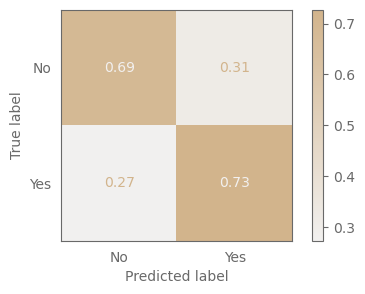

In [47]:
model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), categorical_features),
        remainder='passthrough',
        verbose_feature_names_out=False,
    ),
    RandomForestClassifier(max_depth=8,
                           random_state=24,
                           class_weight=class_weight),
)

train_model(model, X_train, y_train)

model.fit(X_train, y_train)
predict = model.predict(X_test)

print(classification_report(y_test, predict))

plt.rcParams['figure.figsize'] = (5, 3)

cmap = sns.light_palette(COLOR_PLOT, as_cmap=True)
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                      normalize='true',
                                      display_labels=['No', 'Yes'],
                                      cmap=cmap)

plt.show()

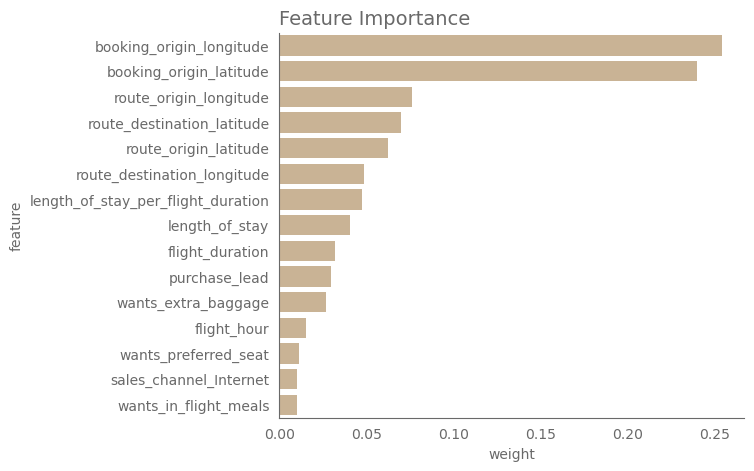

In [48]:
explanation = eli5.explain_weights(
    model[1], top=15, feature_names=model[0].get_feature_names_out()
)
df_feature_importance = eli5.format_as_dataframe(explanation)

plt.figure(figsize=(6, 5))
plt.title('Feature Importance', loc='left')
ax = sns.barplot(df_feature_importance,
                 y='feature', x='weight',
                 color=COLOR_PLOT)
ax.spines[['top', 'right']].set_visible(False)

plt.show()